# Custom dataset

Test class to create a custom MNIST dataset for  generating number from 0 to 999 in a single image

# Spatial dimension concat

Here i will create a single image by concatenating multiple single digit images on the width dimension
<br> (probably this will generate image of different size due to the fact that number from 0 to 9 are shorter than number from 10 to 99 and so on)

In [211]:
import torch
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
#import numpy as np

In [ ]:
mnist_mean = 0.1307
mnist_std = 0.3081

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize(mnist_mean, mnist_std)]
)

transform = transforms.Compose(
    [transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mnist_mean, mnist_std)]
)

to_pil = transforms.ToPILImage()

def denormalize(img):
    img = img*mnist_std
    return img + mnist_mean

In [213]:
batch_size_train = 64
batch_size_test = 100

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size_train,
    shuffle=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size_test,
    shuffle=False
)

In [214]:
print(f'train_dataset len: {len(train_dataset)}, train_loader len: {len(train_loader)}')
print(f'test_dataset len: {len(test_dataset)}, test_loader len: {len(test_loader)}')

train_dataset len: 60000, train_loader len: 938
test_dataset len: 10000, test_loader len: 100


torch.Size([64, 1, 28, 28])
tensor(7)


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

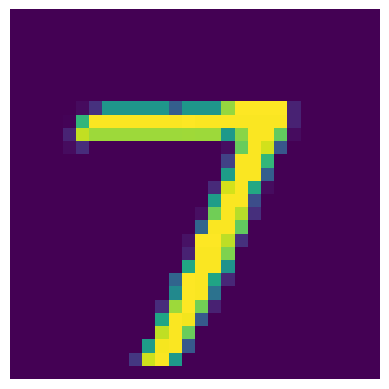

In [226]:
image, label = next(iter(train_loader))
print(image.shape)
print(label[0])
plt.imshow(to_pil(denormalize(image[0])))
plt.axis('off')

In [405]:
import random
from PIL import Image

class DynamicWMNIST(torchvision.datasets.MNIST):
    def __init__(self, root="./data", train=True, min_digits=1, max_digits=3, dataset_size=60000, transform=None, download=True):
        super().__init__(root=root, train=train, transform=transform, download=download)

        self.min_digits = min_digits
        self.max_digits = max_digits
        self.dataset_size = dataset_size

        self.label_to_indices = {
            i: torch.where(self.targets == i)[0] for i in range(10)
        }

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        n_digits = random.randint(self.min_digits,self.max_digits)
        number = random.randint(0 if n_digits == 1 else 10**(n_digits-1), 10**n_digits - 1)
        digits = list(str(number))

        digit_images = []
        for d in digits:
            label = int(d)
            indices = self.label_to_indices[label]
            chosen_idx = indices[torch.randint(len(indices), (1,)).item()]
            img = self.data[chosen_idx]
            img = img.unsqueeze(0)
            digit_images.append(img)
        concat_img = torch.cat(digit_images, dim=2)

        if transform:
            concat_img = transform(concat_img)

        return concat_img, number, n_digits


In [438]:
import random
from PIL import Image

class DynamicDMNIST(torchvision.datasets.MNIST):
    def __init__(self, root="./data", train=True, min_digits=1, max_digits=3, dataset_size=60000, transform=None, download=True):
        super().__init__(root=root, train=train, transform=transform, download=download)

        self.min_digits = min_digits
        self.max_digits = max_digits
        self.dataset_size = dataset_size

        self.label_to_indices = {
            i: torch.where(self.targets == i)[0] for i in range(10)
        }

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        n_digits = random.randint(self.min_digits,self.max_digits)
        number = random.randint(0 if n_digits == 1 else 10**(n_digits-1), 10**n_digits - 1)
        digits = list(str(number))

        digit_images = []
        for d in digits:
            label = int(d)
            indices = self.label_to_indices[label]
            chosen_idx = indices[torch.randint(len(indices), (1,)).item()]
            img = self.data[chosen_idx]
            img = img.unsqueeze(0)
            digit_images.append(img)
        concat_img = torch.cat(digit_images, dim=0)

        if transform:
            concat_img = transform(concat_img)

        return concat_img, number, n_digits


In [432]:
def my_collate(batch):
    imgs, labels, n_digits = zip(*batch)
    return list(imgs), list(labels), list(n_digits)

In [419]:
ds = DynamicWMNIST(transform=transform)
dl = torch.utils.data.DataLoader(
    ds,
    batch_size=batch_size_train,
    shuffle=True,
    collate_fn=my_collate
)

100
torch.Size([1, 28, 56])
2
29
200
torch.Size([1, 28, 56])
2
93
300
torch.Size([1, 28, 28])
1
0
400
torch.Size([1, 28, 56])
2
97
500
torch.Size([1, 28, 28])
1
5
600
torch.Size([1, 28, 84])
3
930
700
torch.Size([1, 28, 84])
3
481
800
torch.Size([1, 28, 28])
1
0
900
torch.Size([1, 28, 56])
2
79
938


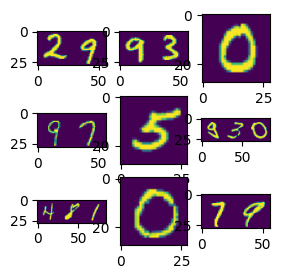

In [429]:
counter = 0
figure = plt.figure(figsize=(3, 3))
for i, data in enumerate(dl):
    counter += 1
    image, number, n_digits = data
    if counter%100 == 0:
        print(counter)

    #print(counter)
    #plt.figure(figsize=(3, 3))
        figure.add_subplot(3, 3, i//100+1)
        plt.imshow(to_pil(denormalize(image[0])))
        print(image[0].shape)
        print(n_digits[0])
        print(number[0])
print(counter)

In [440]:
ds = DynamicDMNIST(transform=transform)
dl = torch.utils.data.DataLoader(
    ds,
    batch_size=batch_size_train,
    shuffle=True,
    collate_fn=my_collate
)

100
torch.Size([2, 28, 28])
2
59
200
torch.Size([1, 28, 28])
1
9
300
torch.Size([3, 28, 28])
3
888
400
torch.Size([2, 28, 28])
2
26
500
torch.Size([1, 28, 28])
1
6
600
torch.Size([1, 28, 28])
1
5
700
torch.Size([2, 28, 28])
2
79
800
torch.Size([3, 28, 28])
3
975
900
torch.Size([2, 28, 28])
2
43
938


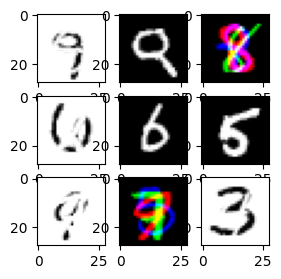

In [444]:
counter = 0
figure = plt.figure(figsize=(3, 3))
for i, data in enumerate(dl):
    counter += 1
    image, number, n_digits = data
    if counter%100 == 0:
        print(counter)

    #print(counter)
    #plt.figure(figsize=(3, 3))
        figure.add_subplot(3, 3, i//100+1)
        plt.imshow(to_pil(denormalize(image[0].squeeze())),cmap='gray')
        print(image[0].shape)
        print(n_digits[0])
        print(number[0])
print(counter)

# Testset
adesso iniziero a creare il testset

In [ ]:
import os


In [ ]:
#scrivi due for annidati per generare il dataset da 10 a 99 e per quello da 100 a 999 fai tre for annidati 
#così potrai utlizzare la funzione che ti ha consigliato chatgpt per estrarre i valori dal dataset originale MNIST
#per generare le immagini concatenate